In [7]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from topic import ScrollingCorpus
from elastic import elasticsearch_client
import re


In [9]:

client = elasticsearch_client("../credentials.json", "../http_ca.crt")
index_name = "arxiv-index"
corpus = ScrollingCorpus(client, index_name, "../models/counts.dict", "../models/phrase_model.pkl", doc_field="summary", fields_to_keep=["summary"])

['summary', 'summary']


In [13]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

lda = LdaMulticore(corpus, id2word=corpus.dictionary, num_topics=10, workers=6, eta=0.7)
#lda = LdaModel(corpus, id2word=corpus.dictionary, num_topics=6, alpha="auto", eta="auto")
lda.save("../models/lda.model")

In [14]:
def topic_to_words(topic: tuple) -> list:
    find = re.findall(r"\"(\w+)\"", topic)
    return find

topic_words = []

for i, topic in enumerate(lda.print_topics()):
    print(topic)
    topic_words.append(topic_to_words(topic[1]))

print(topic_words)

(0, '0.004*"model" + 0.003*"data" + 0.003*"time" + 0.003*"results" + 0.003*"models" + 0.002*"different" + 0.002*"study" + 0.002*"energy" + 0.002*"observed" + 0.002*"present"')
(1, '0.005*"model" + 0.003*"energy" + 0.003*"quantum" + 0.003*"results" + 0.003*"galaxies" + 0.002*"present" + 0.002*"study" + 0.002*"field" + 0.002*"based" + 0.002*"emission"')
(2, '0.004*"model" + 0.003*"mass" + 0.003*"results" + 0.003*"energy" + 0.003*"based" + 0.002*"study" + 0.002*"time" + 0.002*"data" + 0.002*"present" + 0.002*"models"')
(3, '0.005*"model" + 0.004*"galaxies" + 0.003*"models" + 0.003*"field" + 0.002*"phase" + 0.002*"study" + 0.002*"mass" + 0.002*"results" + 0.002*"density" + 0.002*"data"')
(4, '0.004*"model" + 0.003*"data" + 0.003*"results" + 0.003*"quantum" + 0.002*"method" + 0.002*"mass" + 0.002*"present" + 0.002*"models" + 0.002*"states" + 0.002*"observed"')
(5, '0.003*"stars" + 0.003*"present" + 0.002*"model" + 0.002*"energy" + 0.002*"results" + 0.002*"study" + 0.002*"properties" + 0.002

In [15]:
topic_matrix = []

for doc in corpus:
    topic_vector = lda.get_document_topics(doc, minimum_probability=0)
    topic_vector = np.array([prob for _, prob in topic_vector])
    topic_matrix.append(topic_vector)

topic_matrix = np.array(topic_matrix)
print(topic_matrix)

[[1.1747579e-01 1.1651589e-03 1.1651549e-03 ... 1.1651551e-03
  7.4140471e-01 1.1651448e-03]
 [2.5683825e-03 2.5683756e-03 2.5683949e-03 ... 2.5684068e-03
  2.5683213e-03 2.5683341e-03]
 [2.3285674e-03 2.3285237e-03 2.3286154e-03 ... 2.3284901e-03
  2.3285367e-03 2.3286464e-03]
 ...
 [2.5677281e-03 9.7689170e-01 2.5675446e-03 ... 2.5676317e-03
  2.5675634e-03 2.5675148e-03]
 [8.4947696e-04 8.4949966e-04 8.4948441e-04 ... 8.4947137e-04
  8.4947632e-04 8.4952795e-04]
 [1.0441506e-03 1.0441003e-03 1.0441474e-03 ... 2.2972384e-01
  1.0441137e-03 1.0441740e-03]]


Clustering time

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best = [0, 0, None]

for n in range(2, 15):
    clustering_model = KMeans(n_clusters = n)
    clustering_model.fit(topic_matrix)
    #Evaluate clustering:
    score = silhouette_score(topic_matrix, clustering_model.labels_)

    if score > best[0]:
        best[0] = score
        best[1] = n
        best[2] = clustering_model

    print(score)

clustering_model = best[2]

print(f"Best score: {best[0]} ({best[1]} clusters)")
print(best[2].labels_)

0.16077767
0.21411377
0.28493157
0.38537443
0.41540802
0.48510796
0.55159235
0.6059941
0.67515576
0.64928955
0.63376004
0.6243706
0.6132135
Best score: 0.675155758857727 (10 clusters)
[4 3 3 ... 5 1 3]


Visualize best model

[[ 0.03581277 -0.085362  ]
 [-0.05357444 -0.0781939 ]
 [-0.05363543 -0.07831336]
 ...
 [-0.21097267 -0.50147706]
 [ 0.856184    0.1848945 ]
 [-0.05081858 -0.0730398 ]]
[0.67515576, 10, KMeans(n_clusters=10)]


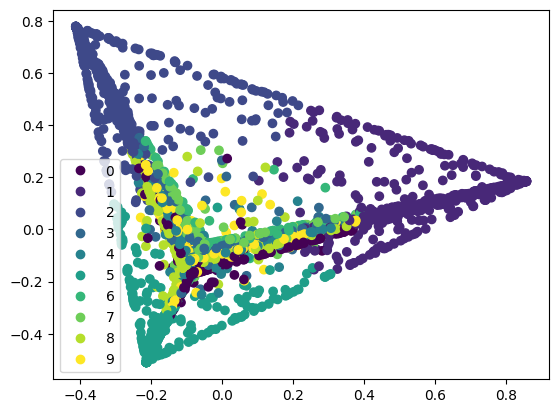

In [17]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(topic_matrix)
print(reduced)

fig, ax = plt.subplots()
print(best)

scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c = best[2].labels_)

ax.legend(*scatter.legend_elements())

Cluster centers

In [18]:
print(clustering_model.cluster_centers_)

strong_topics = {}

for i, center in enumerate(clustering_model.cluster_centers_):
    for j, topic in enumerate(center):
        if topic > 0.7:
            strong_topics[i] = j
            print(f"Cluster {i:02} has strong topic {j:02} ({topic})")

print(strong_topics)

[[0.8241354  0.02690314 0.02140241 0.01971604 0.03155062 0.01236951
  0.01293631 0.01319386 0.0180923  0.01970033]
 [0.02009598 0.02145831 0.02020641 0.02590699 0.8342098  0.01092367
  0.01678774 0.01560989 0.01551241 0.0192888 ]
 [0.01831197 0.02339873 0.0195889  0.84267974 0.02813434 0.01059138
  0.01249799 0.00810593 0.01571815 0.02097283]
 [0.02489246 0.02549782 0.01539289 0.02263866 0.03110226 0.01189373
  0.82146746 0.01159145 0.01596742 0.01955575]
 [0.01879216 0.0233249  0.02352893 0.02129316 0.0239723  0.01215483
  0.01592949 0.00743194 0.83704853 0.01652382]
 [0.02463578 0.83189154 0.01923134 0.02391365 0.02575714 0.01249443
  0.01433216 0.00895339 0.01660045 0.02219006]
 [0.01928385 0.02493518 0.02026316 0.02553984 0.0294155  0.00788465
  0.00860899 0.831208   0.00931043 0.02355047]
 [0.01506174 0.02692506 0.0163607  0.02450965 0.0274922  0.84547555
  0.00984117 0.00731151 0.01325593 0.01376648]
 [0.01765152 0.02315168 0.83443946 0.02761533 0.02381738 0.011147
  0.01127786 0

We observe that each cluster essentially corresponds to one topic

A topic that is strong for that particular cluster

Let's take one of the clusters and the topic, and see if they are related

In [19]:
clusters = [[] for _ in range(len(clustering_model.labels_))]

for i, label in enumerate(clustering_model.labels_):
    clusters[label].append(i+1)

cluster_test = 0

print(f"Here are the docs for cluster {cluster_test}:")
print(clusters[cluster_test])

print(f"\nTopic of cluster {cluster_test}:")
print(topic_words[strong_topics[cluster_test]])

print()

#Let's see what elasticsearch has to say
def get_doc_keywords(doc: int, minor: bool = True) -> list[str]:
    resp = client.get(index=index_name, id=f"{doc:05}", filter_path="_source.major_subjects,_source.minor_subjects")
    resp = resp["_source"]
    resp = resp["major_subjects"] + resp["minor_subjects"]
    return list(map(lambda kword: re.match(r"([\w\s]+)(:.+)?", kword).group(1), resp))

for doc in clusters[cluster_test]:
    print(get_doc_keywords(doc))

Here are the docs for cluster 0:
[7, 14, 18, 23, 28, 31, 43, 45, 48, 61, 62, 69, 75, 82, 104, 112, 128, 129, 135, 137, 152, 172, 189, 197, 200, 205, 231, 253, 257, 264, 270, 276, 277, 279, 280, 302, 307, 308, 312, 315, 323, 326, 334, 335, 336, 352, 359, 377, 407, 419, 428, 434, 442, 452, 456, 457, 471, 476, 492, 494, 507, 515, 526, 540, 564, 579, 589, 597, 602, 606, 611, 637, 645, 658, 661, 663, 676, 682, 689, 690, 700, 705, 715, 746, 760, 764, 772, 773, 796, 806, 808, 848, 851, 863, 899, 928, 937, 938, 947, 952, 958, 962, 979, 981, 986, 994, 1001, 1030, 1032, 1036, 1038, 1086, 1093, 1113, 1116, 1117, 1126, 1129, 1135, 1164, 1166, 1171, 1214, 1216, 1236, 1255, 1273, 1274, 1292, 1293, 1318, 1334, 1352, 1370, 1371, 1375, 1376, 1418, 1421, 1434, 1460, 1466, 1481, 1499, 1505, 1506, 1525, 1549, 1557, 1562, 1569, 1600, 1606, 1613, 1616, 1619, 1620, 1624, 1630, 1644, 1645, 1670, 1680, 1686, 1687, 1691, 1693, 1694, 1698, 1702, 1712, 1718, 1720, 1725, 1735, 1736, 1756, 1761, 1767, 1773, 1782, 1

NotFoundError: NotFoundError(404, '{}')

Let's take the user queries and pass them through the LDA model

I want to see the topic distribution of each query

(what if the topic words are not contained in the query?)

Let's just see what happens

In [20]:
from collection_helper import parse_queries

queries = parse_queries("../collection")

for query in queries:
    print(lda.get_document_topics(corpus.doc_to_vec(query.text)))


ImportError: cannot import name 'parse_queries' from 'collection_helper' (/home/zoukos/ceid/final/collection_helper.py)

Nevermind this was stupid